## INDENG 223 - Final Project

**Authors:** Matteo Santamaria, Qiran Dong, Divyansh Saksena

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

### Exercise A: Almgren-Chriss for one asset

We will examine Apple (ticker APPL) over the time period `[2022-02-01, 2022-05-01)`.

In [2]:
df = yf.Ticker("AAPL").history(start="2022-02-01", end="2022-05-01", interval="1d")

df.head(3)[["Open", "High", "Low", "Close"]]

,Open,High,Low,Close
Date,,,,
2022-02-01 00:00:00-05:00,173.005904,173.831116,171.315716,173.602448
2022-02-02 00:00:00-05:00,173.741641,174.865126,172.329837,174.825348
2022-02-03 00:00:00-05:00,173.473198,175.223052,171.126815,171.902313


In [3]:
X = df["Volume"].mean() / 4
X

22161741.93548387

The initial volume to liquidate, denoted by `X`, is roughly 22 million shares.

To estimate the volatility parameter $\sigma^2$, we will compute

$$\hat{\sigma}^2_N := \frac{1}{N} \sum_{k=1}^N \left( S_{t_k} - S_{t_{k-1}} \right)^2$$

Note that if we assume prices evolve according to $S_{t_k} = S_{t_{k - 1}} + \sigma \xi_k$ where $\xi_k$ are iid random variables with zero mean and unit variance, then we have

$$\mathbb{E}\left[ \hat{\sigma}^2_N \right] = \sigma^2$$

In [4]:
vol = df["Close"].diff().pow(2).mean()
vol

9.822067161995276

In [5]:
def optimal_trajectory(*, theta: float, nu: float, gamma: float) -> pd.Series:
    """Compute the optimal trading trajectory.

    Notes
    -----
    The parameter theta represents lambda in the Almgren-Chriss paper.
    It is the risk-aversion parameter.

    Also note that tau = 1, so it is dropped from many of the calculations.
    """
    N = T = len(df["Close"])

    trajectory = np.empty(N)

    for j in range(N):
        nu_tilde = nu - gamma / 2
        kappa_tilde = np.sqrt(theta * vol / nu_tilde)
        kappa = np.arccosh((kappa_tilde**2) / 2 + 1)
        trajectory[j] = np.sinh(kappa * (T - j)) / np.sinh(kappa * T) * X

    return pd.Series(trajectory)

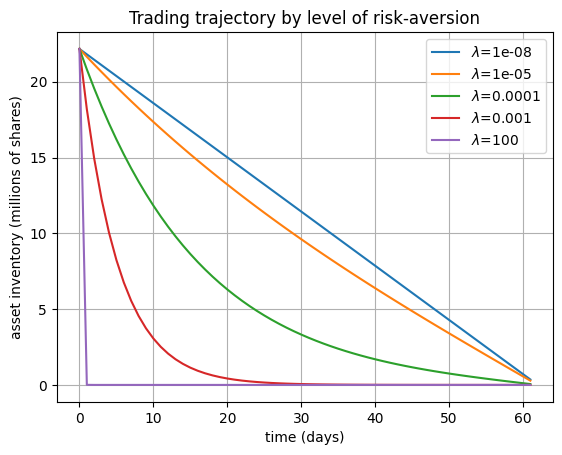

In [6]:
(
    pd.DataFrame(
        {
            rf"$\lambda$={theta}": optimal_trajectory(theta=theta, nu=0.5, gamma=0.5)
            for theta in [1e-8, 1e-5, 1e-4, 1e-3, 100]
        }
    )
    .div(1e6)
    .plot(
        title="Trading trajectory by level of risk-aversion",
        xlabel="time (days)",
        ylabel="asset inventory (millions of shares)",
        grid=True,
    )
);

We can see that as the level of risk-aversion increases, the investor prefers to trade more quickly. That is to say, she avoids holding inventory (and hence carrying risk) late into the trading window. We can also examine how the trading strategy changes with $\nu$.

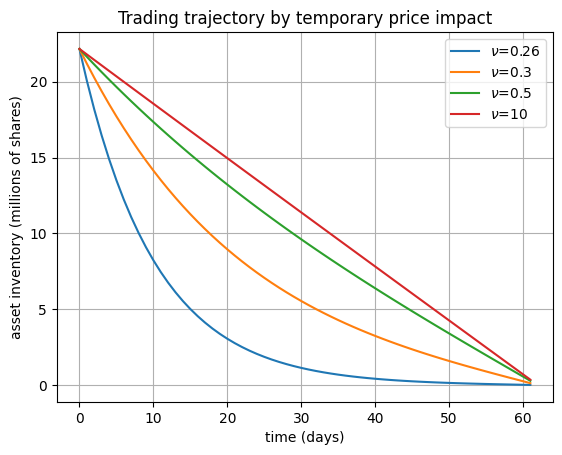

In [7]:
(
    pd.DataFrame(
        {
            rf"$\nu$={nu}": optimal_trajectory(theta=1e-5, nu=nu, gamma=0.5)
            for nu in [0.26, 0.3, 0.5, 10]
        }
    )
    .div(1e6)
    .plot(
        title="Trading trajectory by temporary price impact",
        xlabel="time (days)",
        ylabel="asset inventory (millions of shares)",
        grid=True,
    )
);

The plot demonstrates that as $\nu$, the strength of the temporary price impact, increases the investor prefers to spread her trading out more evenly throughout the interval. Lastly, we can look at the effect of $\gamma$ on the optimal trajectory.

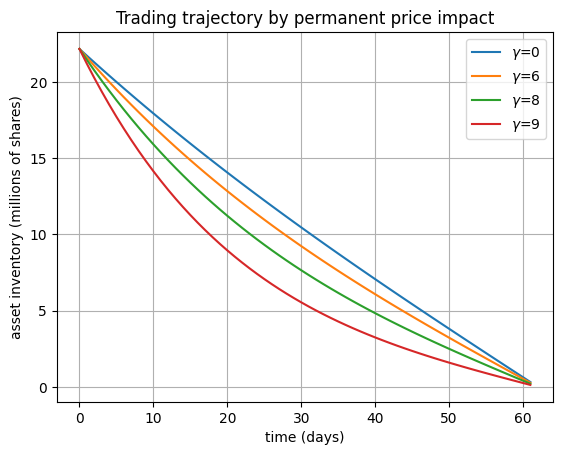

In [8]:
(
    pd.DataFrame(
        {
            rf"$\gamma$={gamma}": optimal_trajectory(theta=1e-4, nu=5, gamma=gamma)
            for gamma in [0, 6, 8, 9]
        }
    )
    .div(1e6)
    .plot(
        title="Trading trajectory by permanent price impact",
        xlabel="time (days)",
        ylabel="asset inventory (millions of shares)",
        grid=True,
    )
);

For a fixed level of $\lambda$, we see that larger levels of $\gamma$ encourage the investor to sell her shares more quickly. This can be interpreted as suggesting that there is no benefit in spreading out trading activities if the permanent price impact dominates the dynamics. In this case, we can still reduce the variance by trading more quickly in the beginning.

### Exercise B: Glosten-Milgrom model

### Part I. Optimal strategy of informed traders

**Part 1.** $\text{payoff} = (v - P)D$

**Part 2.** From **Part 1.**, we see that a trade can only generate positive payoff if:

- the value is greater than the price (i.e. $V_H\geq a$) when we buy, or
- the value is smaller than the price (i.e. $V_L\leq b$) when we sell.

**Part 3.** Whether $v = V_H$ or $v = V_L$, the optimal strategy of the informed trader is to submit a buy order when $a \leq v$ and to submit a sell order when $b \geq v$.

**Part 4.** 

$\Pr(\{\text{buy order arrives}\}|v = V_H)$
\begin{equation*}
\begin{split}
 & = \Pr(\{\text{uninformed buy}\}|v = V_H) + \Pr(\{\text{informed buy}\}|v = V_H)\\
 & = (1 - \alpha)(1/2) + \alpha \Pr(V_H \geq a)\\
 & = (1 - \alpha)(1/2) + \alpha\\
\end{split}
\end{equation*}

$\Pr(\{\text{sell order arrives}\}|v = V_H)$
\begin{equation*}
\begin{split}
 & = \Pr(\{\text{uninformed buy}\}|v = V_H) + \Pr(\{\text{informed buy}\}|v = V_H)\\
 & = (1 - \alpha)(1/2) + \alpha \Pr(V_H \leq b)\\
 & = (1 - \alpha)(1/2)\\
\end{split}
\end{equation*}

**Part 5.** Observe that $\Pr(\{\text{buy order arrives}\}|v = V_H) > \Pr(\{\text{sell order arrives}\}|v = V_H)$, so more buy orders imply the asset being at higher value.

### Part II. Optimal bid and ask prices: one step model

**Part 1.** Since the order is a buy order from informed traders, by analysis in **Part I.**, we know that the value of the asset must be $v = V_H$.

profit from uninformed trader
\begin{equation*}
\begin{split}
 & = \text{MM's payoff}\cdot \Pr(\text{uninformed buy}|\text{buy})\\
 & = (a - \mu)\cdot \frac{\Pr(\text{uninformed buy})}{\Pr(\text{informed buy}) + \Pr(\text{uninformed buy})}\\
 & = \delta^a \cdot \frac{(1-\alpha)(1/2)}{\theta\alpha + (1-\alpha)(1/2)}\\
\end{split}
\end{equation*}

**Part 2.** profit from informed trader
\begin{equation*}
\begin{split}
 & = \text{MM's payoff}\cdot \Pr(\text{informed buy}|\text{buy})\\
 & = (a - V_H)\cdot \frac{\Pr(\text{informed buy})}{\Pr(\text{informed buy}) + \Pr(\text{uninformed buy})}\\
 & = (\delta^a - (V_H - \mu)) \cdot \frac{\theta\alpha}{\theta\alpha + (1-\alpha)(1/2)}\\
\end{split}
\end{equation*}

**Part 3.** Since the order is a sell order from informed traders, by analysis in **Part I.**, we know that the value of the asset must be $v = V_L$.

\begin{equation*}
\begin{split}
 X^a
 & = \text{profit from uninformed trader} + \text{profit from informed trader}\\
 & = \delta^a \cdot \frac{(1-\alpha)(1/2)}{\theta\alpha + (1-\alpha)(1/2)} + (\delta^a - (V_H - \mu)) \cdot \frac{\theta\alpha}{\theta\alpha + (1-\alpha)(1/2)}\\
\end{split}
\end{equation*}

**Part 4.** \begin{equation*}
\begin{split}
 X^b
 & = \text{profit from uninformed trader} + \text{profit from informed trader}\\
 & = \delta^b \cdot \frac{(1-\alpha)(1/2)}{(1-\theta)\alpha + (1-\alpha)(1/2)} + (\delta^b + (V_L - \mu)) \cdot \frac{(1-\theta)\alpha}{(1-\theta)\alpha + (1-\alpha)(1/2)}\\
\end{split}
\end{equation*}

**Part 5.** Set $X^a = 0$ and $X^b = 0$, we obtain $\delta^a = \frac{(V_H - \mu)\theta\alpha}{\theta\alpha + (1-\alpha)(1/2)}$, $\delta^b = \frac{(\mu - V_L)(1-\theta)\alpha}{(1-\theta)\alpha + (1-\alpha)(1/2)}$.

### Part III. Multi-period model

**Part 1.** $\mu_0 = \mathbb{E} [v] = V_H\Pr(v = V_H) + V_L\Pr(v = V_L) = \frac{V_H + V_L}{2}$

**Part 2.** 

$$\delta_1^a = \frac{(V_H - \mu_0)(1/2)\alpha}{(1/2)\alpha + (1-\alpha)(1/2)} = \alpha\cdot \frac{V_H - V_L}{2}$$

$$\delta^b = \frac{(\mu_0 - V_L)(1-1/2)\alpha}{(1-1/2)\alpha + (1-\alpha)(1/2)} = \alpha\cdot \frac{V_H - V_L}{2}$$

**Part 3.** $\Delta = \delta_1^a + \delta_1^b = \alpha (V_H - V_L)$.

The spread, which measures the volatility of the asset's price, is an estimation of the volatility of the asset's value. This estimation is scaled by the fraction of traders who know those values; the more informed traders, the more accurate this estimation is. Liquidity (noise) traders do not affect this estimation because their selling and buying at a timestep are completely symmetrical with 0 expected volatility.

**Part 4.** $\mu_t = \mathbb{E} [v|\mathcal{F}_t] = V_H\Pr(v = V_H|\mathcal{F}_t) + V_L\Pr(v = V_L|\mathcal{F}_t) = \theta_tV_H + (1-\theta_t)V_L$

**Part 5.** We apply the result for $\delta^a$, $\delta^b$ from single time period with corresponding adjustments, and obtain

\begin{equation*}
\begin{split}
    \delta_t^a 
    & = \frac{(V_H - \mu_{t-1})\theta_{t-1}\alpha}{\theta_{t-1}\alpha + (1-\alpha)(1/2)}\\
    & = (V_H - \mu_{t-1})\cdot \frac{1}{1 + \frac{(1-\alpha)(1/2)}{\theta_{t-1}\alpha}}\\
    & = (V_H - (\theta_{t-1}V_H + (1-\theta_{t-1})V_L))\cdot \frac{1}{1 + \frac{1-\alpha}{\alpha}\cdot\frac{1/2}{\theta_{t-1}}}\\
    & = (V_H - V_L) \frac{(1-\theta_{t-1})\theta_{t-1}\alpha}{\theta_{t-1}\alpha + (1-\alpha)/2}\\
\end{split}
\end{equation*}

and 

\begin{equation*}
\begin{split}
    \delta^b
    & = \frac{(\mu_{t-1} - V_L)(1-\theta_{t-1})\alpha}{(1-\theta_{t-1})\alpha + (1-\alpha)(1/2)}\\
    & = (\mu_{t-1} - V_L) \cdot \frac{1}{1 + \frac{(1-\alpha)(1/2)}{(1-\theta_{t-1})\alpha}}\\
    & = ((\theta_{t-1}V_H + (1-\theta_{t-1})V_L) - V_L) \cdot \frac{1}{1 + \frac{1-\alpha}{\alpha}\cdot\frac{1/2}{1-\theta_{t-1}}}\\
    & = (V_H - V_L) \frac{(1-\theta_{t-1})\theta_{t-1}\alpha}{(1-\theta_{t-1})\alpha + (1-\alpha)/2}.\\
\end{split}
\end{equation*}

**Part 6.** \begin{equation*}
\begin{split}
   \Delta_t & = \delta_t^a + \delta_t^b\\
   & = (V_H - V_L) \frac{(1-\theta_{t-1})\theta_{t-1}\alpha}{\theta_{t-1}\alpha + (1-\alpha)/2} + (V_H - V_L) \frac{(1-\theta_{t-1})\theta_{t-1}\alpha}{(1-\theta_{t-1})\alpha + (1-\alpha)/2}\\
   & =  (V_H - V_L)(1-\theta_{t-1})\theta_{t-1}\alpha(\frac{1}{\theta_{t-1}\alpha + (1-\alpha)/2} + \frac{1}{(1-\theta_{t-1})\alpha + (1-\alpha)/2})\\
\end{split}
\end{equation*}

**Part 7.** Observe that:

- $(1-\theta)\theta$ is maximized at $\theta = 1/2$
- $\frac{1}{\theta\alpha + (1-\alpha)/2} + \frac{1}{(1-\theta)\alpha + (1-\alpha)/2}$ is maximized at $\theta = 1/2$
- $V_H-V_L \geq 0$, $\alpha \geq 0$

Therefore, $\Delta_t$ is maximized at $\theta_{t-1} = 1/2$

### Part IV. Bayesian updates

**Part 1.** \begin{equation*}
\begin{split}
    \theta_t^+ 
    & = \Pr(v = V_H|D_t = 1, \mathcal{F}_{t-1})\\
    & = \frac{\Pr(v = V_H, D_t = 1, \mathcal{F}_{t-1})}{\Pr(D_t = 1, \mathcal{F}_{t-1})}\\
    & = \frac{\Pr(D_t = 1|v = V_H, \mathcal{F}_{t-1})\Pr(v = V_H| \mathcal{F}_{t-1})\Pr(\mathcal{F}_{t-1})}{\Pr(D_t = 1 | \mathcal{F}_{t-1})\Pr(\mathcal{F}_{t-1})}\\
    & = \frac{\Pr(D_t = 1|v = V_H, \mathcal{F}_{t-1})\Pr(v = V_H| \mathcal{F}_{t-1})}{\Pr(D_t = 1 | \mathcal{F}_{t-1})}\\
\end{split}
\end{equation*}

**Part 2.** \begin{equation*}
\begin{split}
    \theta_t^+ 
    & = \Pr(v = V_H|D_t = 1, \mathcal{F}_{t-1})\\
    & = \frac{\Pr(v = V_H, D_t = 1, \mathcal{F}_{t-1})}{\Pr(D_t = 1, \mathcal{F}_{t-1})}\\
    & = \frac{\Pr(D_t = 1|v = V_H, \mathcal{F}_{t-1})\Pr(v = V_H| \mathcal{F}_{t-1})\Pr(\mathcal{F}_{t-1})}{\Pr(D_t = 1 | \mathcal{F}_{t-1})\Pr(\mathcal{F}_{t-1})}\\
    & = \frac{\Pr(D_t = 1|v = V_H, \mathcal{F}_{t-1})\Pr(v = V_H| \mathcal{F}_{t-1})}{\Pr(D_t = 1 | \mathcal{F}_{t-1})}\\
\end{split}
\end{equation*}

### Part V. Numerical example

In [9]:
V_H = 102
V_L = 98

alpha = 0.3

# some useful quanities
x = 1 + alpha
y = 1 - alpha

def run_experiment() -> pd.DataFrame:
    theta = np.empty(101)
    theta[0] = 0.5

    mu = np.empty(101)
    mu[0] = 100

    order = np.random.choice([-1, 1], size=100, p=[0.35, 0.65])

    price = np.empty(100)

    for t in range(100):
        if order[t] > 0:  # <-- buy order
            edge = (V_H - mu[t]) / (1 + y / (2 * alpha * theta[t]))
            price[t] = mu[t] + edge
            theta[t + 1] = x * theta[t] / (y + 2 * alpha * theta[t])
        else:  # <-- sell order
            edge = (mu[t] - V_L) / (1 + y / (2 * alpha * (1 - theta[t])))
            price[t] = mu[t] - edge
            theta[t + 1] = y * theta[t] / (2 * alpha * (1 - theta[t]) + y)

        mu[t + 1] = theta[t + 1] * V_H + (1 - theta[t + 1]) * V_L

    return pd.DataFrame(
        {
            "theta": theta[1:],
            "mu": mu[1:],
            "order": order,
            "price": price,
        }
    )

df = run_experiment()

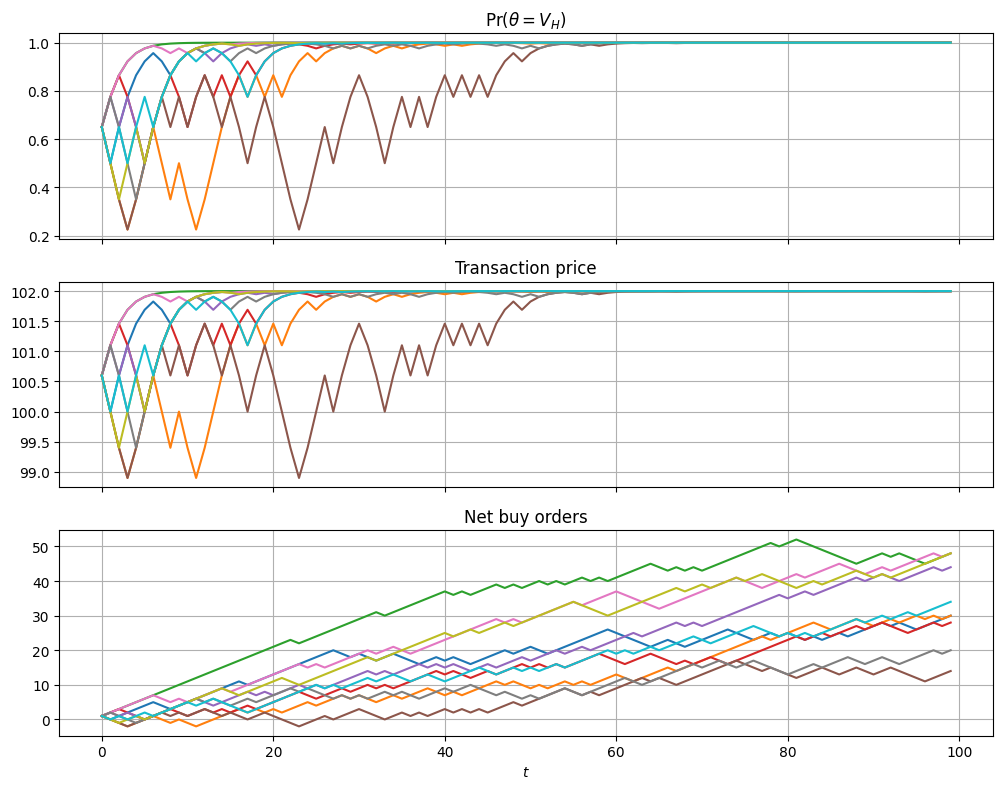

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

for i in range(10):
    df = run_experiment()
    df["theta"].plot(
        ax=ax[0], grid=True, title=r"$\Pr(\theta = V_H)$", xlabel=r"$t$", sharex=True
    )
    df["price"].plot(
        ax=ax[1], grid=True, title="Transaction price", xlabel=r"$t$", sharex=True
    )
    df["order"].cumsum().plot(
        ax=ax[2], grid=True, title="Net buy orders", xlabel=r"$t$", sharex=True
    )

plt.tight_layout()